<div align="center">

![fluxograma_teste_ab_bayesiano_atualizado.png](images\fluxograma_teste_ab_bayesiano_atualizado.png)

</div>


## Import

In [47]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

## Dados

In [ ]:
# Dados iniciais
control_data = [8.1, 7.5, 8.2, 8.0, 7.8, 8.4, 8.2, 7.9, 8.3, 8.1, 7.7, 8.6, 8.0, 7.9, 8.5, 8.2, 7.8, 8.4, 8.3, 8.1, 7.8, 8.2, 7.9, 8.3, 8.4, 8.0, 7.7]
treatment_data = [6.3, 6.2, 6.0, 6.4, 6.1, 6.5, 6.3, 6.7, 6.0, 6.2, 6.6, 6.4, 6.2, 6.1, 6.5, 6.3, 6.2, 6.4, 6.1, 6.7, 6.5, 6.3, 6.6]

# Incrementos semanais (você insere os dados manualmente)
weekly_data = [
    {"control": [5.8, 5.2, 5.9, 6.5, 6.3, 6.7, 6.0, 6.2, 4.6], "treatment": [8.4, 9.3, 6.2, 9.5, 9.0, 10.2, 8.4, 9.1, 9.5, 8.3, 9.4, 10.2, 11.3]},  # Semana 1
    {"control": [8.1, 7.9, 8.0, 7.8], "treatment": [9.1, 9.3]},        # Semana 2
    {"control": [8.3, 8.0], "treatment": [8.2, 9.0, 9.3]},             # Semana 3
    # Adicione mais semanas conforme necessário
]

## Ajuste modelo Bayesiano

### ajuste iterativo

In [ ]:
# Lista para armazenar probabilidades e semanas
probabilities = []
weeks = []

# Modelo inicial e atualização semanal
for week, new_data in enumerate(weekly_data, start=1):
    # Adicionar novos dados
    control_data.extend(new_data["control"])
    treatment_data.extend(new_data["treatment"])

    # # Ajuste do Modelo Bayesiano com dados atualizados
    with pm.Model() as model:
        # Priors
        mu_control = pm.Normal("mu_control", mu=0, sigma=1000)
        mu_treatment = pm.Normal("mu_treatment", mu=0, sigma=1000)
        sigma_control = pm.HalfNormal("sigma_control", sigma=10)
        sigma_treatment = pm.HalfNormal("sigma_treatment", sigma=10)
        
        # Likelihoods
        control = pm.Normal("control", mu=mu_control, sigma=sigma_control, observed=control_data)
        treatment = pm.Normal("treatment", mu=mu_treatment, sigma=sigma_treatment, observed=treatment_data)
        
        # Amostragem
        trace = pm.sample(1000, tune=500, return_inferencedata=False, progressbar=False)
    
    # Calcular probabilidade
    prob = (trace["mu_treatment"] < trace["mu_control"]).mean()
    probabilities.append(prob)
    weeks.append(week)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_control, mu_treatment, sigma_control, sigma_treatment]
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 64 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_control, mu_treatment, sigma_control, sigma_treatment]
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 64 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_control, mu_treatment, sigma_control, sigma_treatment]
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 63 seconds.


### ajuste individual

In [4]:

# Ajuste do Modelo Bayesiano
with pm.Model() as model:
    # Priors para médias
    mu_control = pm.Normal("mu_control", mu=0, sigma=1000)
    mu_treatment = pm.Normal("mu_treatment", mu=0, sigma=1000)
    
    # Priors para desvios padrão
    sigma_control = pm.HalfNormal("sigma_control", sigma=10)
    sigma_treatment = pm.HalfNormal("sigma_treatment", sigma=10)
    
    # Likelihoods
    control = pm.Normal("control", mu=mu_control, sigma=sigma_control, observed=control_data)
    treatment = pm.Normal("treatment", mu=mu_treatment, sigma=sigma_treatment, observed=treatment_data)
    
    # Ajuste do modelo
    trace = pm.sample(2000, tune=1000, return_inferencedata=False)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_control, mu_treatment, sigma_control, sigma_treatment]


c:\Users\willi\codigos\pymc_venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 99 seconds.


atenção com a **definição das priors com dados historicos** (tipo de distribição assumida e valor dos parametros)

<div align="center">

![fluxo_estimativa_priors](images\fluxo_estimativa_priors.png)

</div>

In [48]:
trace.varnames

['mu_control',
 'mu_treatment',
 'sigma_control_log__',
 'sigma_treatment_log__',
 'sigma_control',
 'sigma_treatment']

In [ ]:
trace['mu_control']

7.608115935808921

O fit gera um objeto **multitrace**, que é ideal para os calculos de inferencia mas não para viz

Para vizualizações é indicado usar um objeto **inferencedata** da lib arviz

Assim o trace deve ser convertido em idata

In [ ]:

# Criar o InferenceData manualmente
idata = az.from_dict(
    posterior={var: trace[var] for var in trace.varnames}  # Converte as variáveis do trace
)

# Resumo Estatístico
summary = az.summary(idata)
summary

arviz - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_control,7.625,0.347,6.949,8.273,0.003,0.002,10499.0,6240.0,NaN
mu_treatment,5.834,0.293,5.265,6.371,0.003,0.002,10428.0,5689.0,NaN
sigma_control_log__,0.624,0.137,0.375,0.890,0.001,0.001,10537.0,5992.0,NaN
sigma_treatment_log__,0.614,0.115,0.402,0.835,0.001,0.001,9448.0,5923.0,NaN
sigma_control,1.884,0.264,1.391,2.358,0.003,0.002,10537.0,5992.0,NaN
sigma_treatment,1.860,0.219,1.464,2.262,0.002,0.002,9448.0,5923.0,NaN


## Probabilidade de o Tratamento ser melhor que o Controle

In [ ]:
prob = (trace["mu_treatment"] < trace["mu_control"]).mean()
print(f"Probabilidade de o Tratamento ser menor que o Controle: {prob:.2%}")

Probabilidade de o Tratamento ser menor que o Controle: 99.99%


A operação trace["mu_treatment"] < trace["mu_control"] faz uma comparação elemento a elemento entre esses arrays e retorna um array booleano:

* True se 𝜇treatment<𝜇control
* False caso contrário.

O método .mean() calcula a média dos valores no array:
Soma todos 1 para True e 0 para False. Divide pelo número total de elementos.

**A média do array booleano é a proporção de True na amostra**

**A proporção é a probabilidade estimada de Trues = P(trace["mu_treatment"] < trace["mu_control"])**

## Intervalo de Confiança

In [ ]:
# Intervalo de Credibilidade para Controle
cred_control = np.percentile(trace["mu_control"], [2.5, 97.5])
print(f"Intervalo de Credibilidade (Controle): {cred_control}")

# Intervalo de Credibilidade para Tratamento
cred_treatment = np.percentile(trace["mu_treatment"], [2.5, 97.5])
print(f"Intervalo de Credibilidade (Tratamento): {cred_treatment}")


Intervalo de Credibilidade (Controle): [6.93279491 8.32521291]
Intervalo de Credibilidade (Tratamento): [5.25190819 6.41120593]


## PDF vs CDF

<div align="center">

![curvas_PDF_CDF.png](images\curvas_PDF_CDF.png)

</div>

## gráfico distribuições posteriores de cada grupo PDF

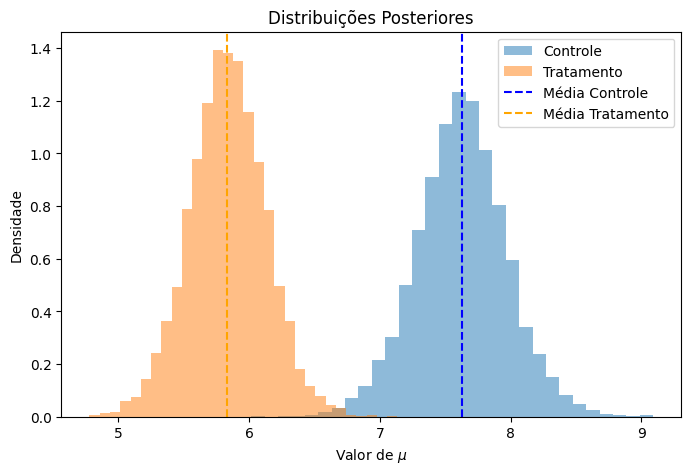

In [28]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(trace["mu_control"], bins=30, alpha=0.5, label="Controle", density=True)
plt.hist(trace["mu_treatment"], bins=30, alpha=0.5, label="Tratamento", density=True)
plt.axvline(np.mean(trace["mu_control"]), color='blue', linestyle='dashed', label='Média Controle')
plt.axvline(np.mean(trace["mu_treatment"]), color='orange', linestyle='dashed', label='Média Tratamento')
plt.title("Distribuições Posteriores")
plt.xlabel("Valor de $\\mu$")
plt.ylabel("Densidade")
plt.legend()
plt.show()


Eixo densidade de probabilidade: é uma função do quão provável é encontrar x em torno de um valor. 

Uma densidade mais **alta em y significa que o valor de 𝜇 é mais provável dentro da região**.

O **valor de y não é probabilidade direta**, é a densidade de probabilidade por unidade no eixo x.

Probabilidade em uma faixa:

* Para calcular a probabilidade da variável estar em uma faixa, integramos a densidade sobre a faixa (a área sob a curva ou barra no histograma).
Por exemplo, 𝑃(𝑎≤𝑋≤𝑏) é a área da curva de densidade entre 𝑥=𝑎 e 𝑥=𝑏, a largura de uma barra é 𝑑𝑥 e altura 𝑓(𝑥):

<div align="center">

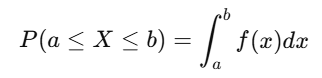

</div>

A densidade de probabilidade pode ser maior que 1 em alguns pontos.

A área total sob a curva é igual a 1, isso representa 100% da probabilidade.

A Probabilidade para **um valor especifico** em uma distribuição continua é zero, pois a prob é a integral em uma faixa de uma função densidade prob. **P(X=a)=0 para variáveis contínuas.**




​


## gráfico PDF da diferença entre grupos

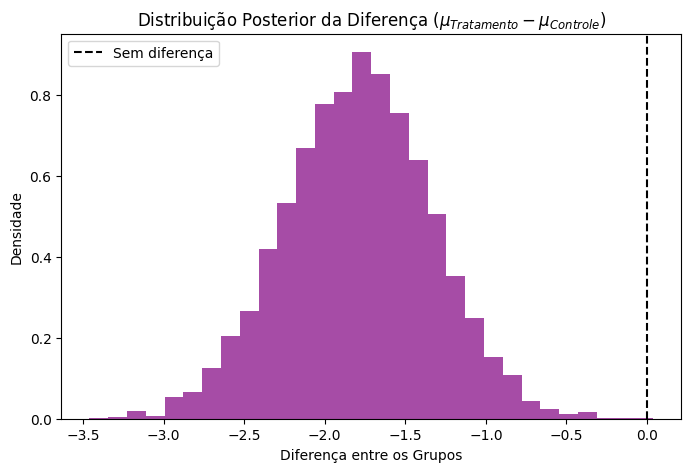

In [ ]:
posterior_diff = trace["mu_treatment"] - trace["mu_control"]

plt.figure(figsize=(8, 5))
plt.hist(posterior_diff, bins=30, alpha=0.7, color='purple', density=True)
plt.axvline(0, color='black', linestyle='dashed', label='Sem diferença')
plt.title("Distribuição Posterior da Diferença ($\\mu_{Tratamento} - \\mu_{Controle}$)")
plt.xlabel("Diferença entre os Grupos")
plt.ylabel("Densidade")
plt.legend()
plt.show()

Distribuição Centrada em 0:

* O tratamento e o controle têm resultados muito próximos.
O tratamento pode não ser significativamente diferente do controle.

Distribuição Principalmente à Direita de 0:

* O tratamento é maior que o controle.
A probabilidade de μtreatment > μcontrol é alta.

Distribuição Principalmente à Esquerda de 0:
* O controle é maior que o tratamento.
* A probabilidade de μtreatment < μcontrol é alta.

Amplitude da Distribuição:

* Se a distribuição for muito larga, a incerteza é alta.
* Se for estreita, a estimativa é mais precisa.

## Gráfico: Função de Distribuição Acumulada (CDF) ed cada grupo

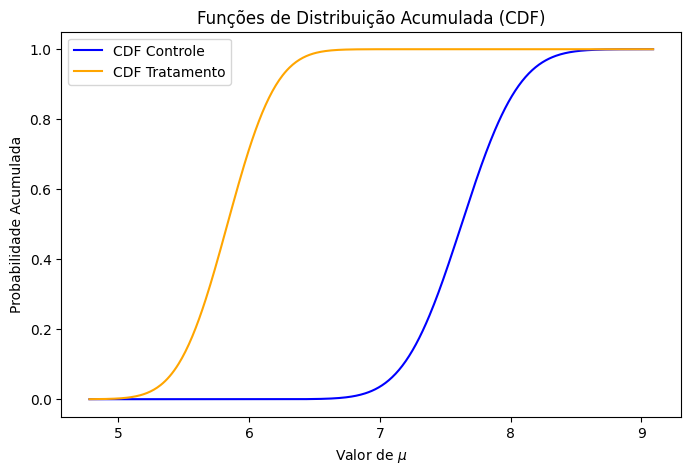

In [31]:

from scipy.stats import norm

x = np.linspace(min(trace["mu_control"].min(), trace["mu_treatment"].min()), 
                max(trace["mu_control"].max(), trace["mu_treatment"].max()), 500)

cdf_control = norm.cdf(x, loc=np.mean(trace["mu_control"]), scale=np.std(trace["mu_control"]))
cdf_treatment = norm.cdf(x, loc=np.mean(trace["mu_treatment"]), scale=np.std(trace["mu_treatment"]))

plt.figure(figsize=(8, 5))
plt.plot(x, cdf_control, label="CDF Controle", color='blue')
plt.plot(x, cdf_treatment, label="CDF Tratamento", color='orange')
plt.title("Funções de Distribuição Acumulada (CDF)")
plt.xlabel("Valor de $\\mu$")
plt.ylabel("Probabilidade Acumulada")
plt.legend()
plt.show()

O que o CDF Mostra:Probabilidade acumulada até um valor específico (𝑃(𝑋≤𝑥)).

Como Interpretar: Leia o valor no eixo 𝑦 para o valor correspondente no eixo 𝑥.

Use a diferença entre 𝐶𝐷𝐹(𝑏) e 𝐶𝐷𝐹(𝑎) para calcular probabilidades em intervalos.

Aplicação em Testes A/B: Comparar probabilidades acumuladas entre dois grupos para identificar diferenças nas distribuições.

Para x = 6.5:

* CDF controle = 0.8 (80% das amostras estão abaixo de 6.5)
* CDF tratamento = 0.9 (90% das amostras estão abaixo de 6.5)
* Tratamento está concentrado em valores mais baixos que o controle

## Gráfico: Evolução Temporal 

Atualização da probabilidade a cada entrada de dados na verossimilhança Reajuste (Novo Fit)

O modelo é ajustado repetidamente, adicionando mais dados a cada iteração. Como funciona:

Ajustes Incrementais:

* Inicia com os dados disponiveis em t0, o modelo bayesiano é ajustado, P1(t > c) é calculada.
* Em cada iteração, mais dados são incrementados na distribuição verossimilhança, o modelo bayesiano é ajustado novamente, P2(t > c) é calculada.
* A probabilidade 𝑃(𝜇treatment>𝜇control) é recalculada após cada ajuste.Eixo 𝑥:
* Representa o tamanho cumulativo do conjunto de dados usado no ajuste.

Vantagens:
* Reflete diretamente o impacto da adição de novos dados na inferência.
* Mais alinhado com cenários de dados que chegam em tempo real.

Limitação:
* Pode ser muito lento, pois cada ponto no gráfico exige um novo ajuste do modelo.


In [38]:
import pymc as pm
import matplotlib.pyplot as plt

# Dados iniciais
control_data = [8.1, 7.5, 8.2, 8.0, 7.8, 8.4, 8.2, 7.9, 8.3, 8.1, 7.7, 8.6, 8.0, 7.9, 8.5, 8.2, 7.8, 8.4, 8.3, 8.1, 7.8, 8.2, 7.9, 8.3, 8.4, 8.0, 7.7]
treatment_data = [6.3, 6.2, 6.0, 6.4, 6.1, 6.5, 6.3, 6.7, 6.0, 6.2, 6.6, 6.4, 6.2, 6.1, 6.5, 6.3, 6.2, 6.4, 6.1, 6.7, 6.5, 6.3, 6.6, 6.0, 6.2, 6.4, 6.1, 6.5, 6.3, 6.4, 6.2, 6.3]

# Incrementos semanais (você insere os dados manualmente)
weekly_data = [
    {"control": [7.8, 8.2, 7.9], "treatment": [6.4, 6.3, 6.2, 6.5]},  # Semana 1
    {"control": [8.1, 7.9, 8.0, 7.8], "treatment": [6.1, 6.3]},        # Semana 2
    {"control": [8.3, 8.0], "treatment": [6.2, 6.0, 6.3]},             # Semana 3
    # Adicione mais semanas conforme necessário
]

# Lista para armazenar probabilidades e semanas
probabilities = []
weeks = []

# Modelo inicial e atualização semanal
for week, new_data in enumerate(weekly_data, start=1):
    control_data.extend(new_data["control"])
    treatment_data.extend(new_data["treatment"])
    print('\n')
    print(control_data)
    print(treatment_data)




[8.1, 7.5, 8.2, 8.0, 7.8, 8.4, 8.2, 7.9, 8.3, 8.1, 7.7, 8.6, 8.0, 7.9, 8.5, 8.2, 7.8, 8.4, 8.3, 8.1, 7.8, 8.2, 7.9, 8.3, 8.4, 8.0, 7.7, 7.8, 8.2, 7.9]
[6.3, 6.2, 6.0, 6.4, 6.1, 6.5, 6.3, 6.7, 6.0, 6.2, 6.6, 6.4, 6.2, 6.1, 6.5, 6.3, 6.2, 6.4, 6.1, 6.7, 6.5, 6.3, 6.6, 6.0, 6.2, 6.4, 6.1, 6.5, 6.3, 6.4, 6.2, 6.3, 6.4, 6.3, 6.2, 6.5]


[8.1, 7.5, 8.2, 8.0, 7.8, 8.4, 8.2, 7.9, 8.3, 8.1, 7.7, 8.6, 8.0, 7.9, 8.5, 8.2, 7.8, 8.4, 8.3, 8.1, 7.8, 8.2, 7.9, 8.3, 8.4, 8.0, 7.7, 7.8, 8.2, 7.9, 8.1, 7.9, 8.0, 7.8]
[6.3, 6.2, 6.0, 6.4, 6.1, 6.5, 6.3, 6.7, 6.0, 6.2, 6.6, 6.4, 6.2, 6.1, 6.5, 6.3, 6.2, 6.4, 6.1, 6.7, 6.5, 6.3, 6.6, 6.0, 6.2, 6.4, 6.1, 6.5, 6.3, 6.4, 6.2, 6.3, 6.4, 6.3, 6.2, 6.5, 6.1, 6.3]


[8.1, 7.5, 8.2, 8.0, 7.8, 8.4, 8.2, 7.9, 8.3, 8.1, 7.7, 8.6, 8.0, 7.9, 8.5, 8.2, 7.8, 8.4, 8.3, 8.1, 7.8, 8.2, 7.9, 8.3, 8.4, 8.0, 7.7, 7.8, 8.2, 7.9, 8.1, 7.9, 8.0, 7.8, 8.3, 8.0]
[6.3, 6.2, 6.0, 6.4, 6.1, 6.5, 6.3, 6.7, 6.0, 6.2, 6.6, 6.4, 6.2, 6.1, 6.5, 6.3, 6.2, 6.4, 6.1, 6.7, 6.5, 6.3, 6.6, 6.0

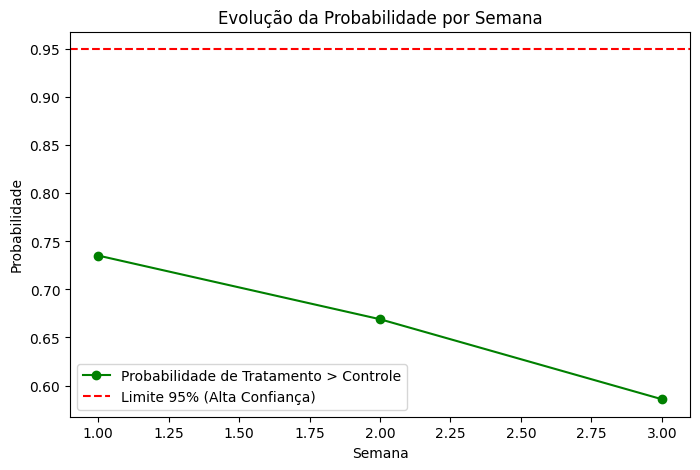

In [46]:
# Plotar o Gráfico de Probabilidades ao Longo do Tempo
plt.figure(figsize=(8, 5))
plt.plot(weeks, probabilities, marker='o', color='green', label="Probabilidade de Tratamento > Controle")
plt.axhline(0.95, color='red', linestyle='dashed', label="Limite 95% (Alta Confiança)")
plt.title("Evolução da Probabilidade por Semana")
plt.xlabel("Semana")
plt.ylabel("Probabilidade")
plt.legend()
plt.show()